**Байесовский классификатор**

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

---

In [2]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

##  загружаем данные 

In [3]:
# data = [
#     np.loadtxt('../data/200_2b/points_1.txt'),
#     np.loadtxt('../data/200_2b/points_2.txt') 
# ]
# lmbd = [ 1.1, 1.1, ]  # коэффициент "цены" ошибки

In [4]:
data = [
    np.loadtxt('../data/399_4/points_b.txt'),
    np.loadtxt('../data/399_4/points_g.txt'),
    np.loadtxt('../data/399_4/points_r.txt'),
    np.loadtxt('../data/399_4/points_y.txt'),
]

lmbd = [ 1.1, 1.1, 1.1, 1.11 ]  # коэффициент "цены" ошибки

In [5]:
# data = [
#     np.loadtxt('../data/6402_2/points_1.txt'),
#     np.loadtxt('../data/6402_2/points_2.txt')
# ]
# lmbd = [ 1.1, 1.1, ]# коэффициент "цены" ошибки


In [6]:
# data = [
#     np.loadtxt('../data/1998_2/points_b.txt'),
#     np.loadtxt('../data/1998_2/points_r.txt')    
# ]
# lmbd = [ 1.1, 1.15, ]# коэффициент "цены" ошибки

---

In [7]:
# собираем вместе
X = np.vstack(data)

n_cls = len(data) # количество классов

# метки классов
y = [ [i]*data[i].shape[0] for i in range(n_cls)]
y = [ item for sublist in y for item in sublist ]
y = np.asarray(y) 

X.shape, y.shape

((399, 2), (399,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=get_seed() )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199, 2), (199,), (200, 2), (200,))

In [9]:
# c = [ ['b','r','g','y'][j] for j in y_train  ]
# plt.figure(figsize=(8,8))
# plt.scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
# plt.grid()
# plt.show()

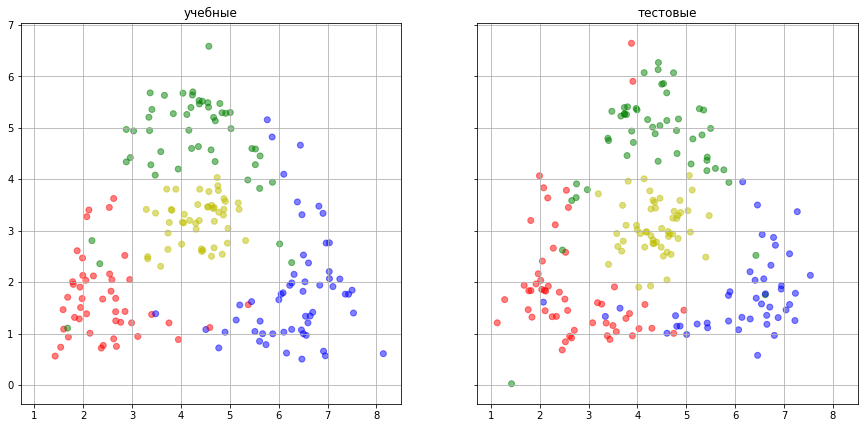

In [10]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(15,7),)
    
c = [ ['b','r','g','y'][j] for j in y_train  ]
axarr[0].set_title('учебные')
axarr[0].set
axarr[0].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in y_test  ]
axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()

##  нормируем данные 

In [11]:
# нормируем данные
scaler = MinMaxScaler([0.0,1.0])
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

---

In [12]:
# ядро Епанечникова
def K(x): return (1.0 - x**2) * 0.75

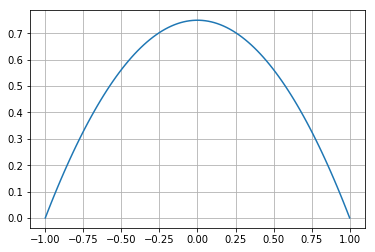

In [13]:
# plt.gcf().set_size_inches(10,3)
x = np.linspace(-1,1,100)
plt.plot(x,K(x))
plt.grid()
plt.show()

##  строим классификатор

In [14]:
def prob(xt,X,y,P,n,h,l): # вероятность принадлежности xt к классу n
    # вероятности принадлежности точек класса t к классу c
    # X,y - учебный набор
    # P - априорные вероятности классов
    # l - цена ошибки классов
    # h - ширина окна
    
    # для каждой точки набора считаем растояние до всех точек учебного класса
    xc = X[y==n] # точки класса
    # дублируем каждую точку по количеству елементов в учебного классе 
    xtr = np.repeat(xt,xc.shape[0],axis=0 )
    # дублируем все точки учебного класса по количеству точек набора
    xtc = np.tile( xc.T, xt.shape[0] ).T
    # евклидова метрика
    r = np.sqrt( np.square( xtr - xtc ).sum(axis=1) )
    # применяем ядро
    r = K(r/h)
    # для каждой точки набора суммируем растояния
    r = r.reshape(xt.shape[0],xc.shape[0]).sum(axis=1)

    return r * P[n] * l[n] / xc.shape[0]


In [15]:
def bayes(xt,X,y,h,l,P): # байесовский классификатор
    # xt - вход 
    # X,y - учебный набор
    # P - априорные вероятности классов
    # l - цена ошибки классов
    # h - ширина окна
    pp = [ prob( xt, X, y, P, c, h, l ) for c in sorted(set(y_train)) ]

    # для кажной точки тестового набора 
    # считаем номер класса с наибольшей вероятностью
    return np.argmax( np.vstack(pp).T, axis=1 )

In [16]:
# априорные вероятности классов
s = np.asarray([ (y_train==c).sum() for c in sorted(set(y_train)) ])
P = s/s.sum()

In [17]:
# LOO ( leave one out) - скользящий контроль,
# количество точек в классе t,
# не попавших в свой класс по вероятностям
def loo(t,X,y,h,l):
    xt = X[y==t] # класс для теста
    ncm = bayes(xt,X,y,h,l,P) # номера классов
    return (ncm != t).sum() # количество ошибок

In [18]:
# подбираем параметр ширины парзоновского окна 
er = {}
for h in range(5,0,-1):
    e = sum([ loo(c,X_train,y_train,h,lmbd) for c in sorted(set(y_train)) ])
    er.update( {e:h}  )
    
# значение ширины парзоновского окна с минимальным количеством ошибок
h = er[min(er)]

h, er

(1, {143: 3, 139: 2, 35: 1})

##  результаты

In [19]:
o = bayes(X_test, X_train, y_train,h,lmbd,P)

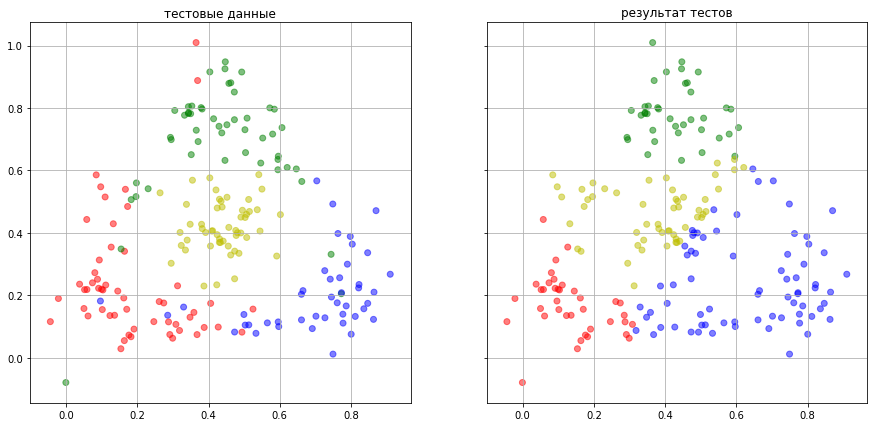

In [20]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(15,7),)
    
c = [ ['b','r','g','y'][j] for j in y_test  ]

axarr[0].set_title('тестовые данные')
axarr[0].set
axarr[0].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in o  ]
axarr[1].set_title('результат тестов')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()


## метрики качества

In [21]:
print( classification_report(y_test,o) )

             precision    recall  f1-score   support

          0       0.59      0.95      0.73        44
          1       0.92      0.65      0.76        54
          2       0.95      0.72      0.82        50
          3       0.68      0.69      0.69        52

avg / total       0.79      0.74      0.75       200



In [22]:
cm = confusion_matrix(y_test,o)


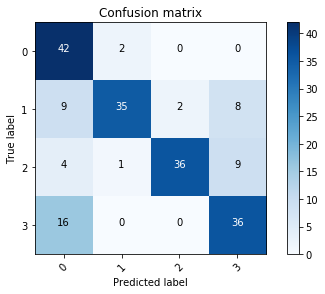

In [23]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

plt.colorbar()

classes = ['neg','pos'] if n_cls<3 else list(range(n_cls))

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
if n_cls<3:
    fpr, tpr, thresholds = roc_curve( y_test, o )
    roc_auc = auc(fpr,tpr)

    plt.figure(figsize=(7,7))
    plt.grid(True)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## карта скоров

In [25]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xx.shape, yy.shape

((50, 50), (50, 50))

In [26]:
xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
xy.shape

(2500, 2)

In [27]:
pp = [ prob( xy, X_train, y_train, P, c, h, lmbd ) for c in sorted(set(y_train)) ]
# [ (min(p),max(p)) for p in  pp ]
# [ len(p) for p in  pp ]

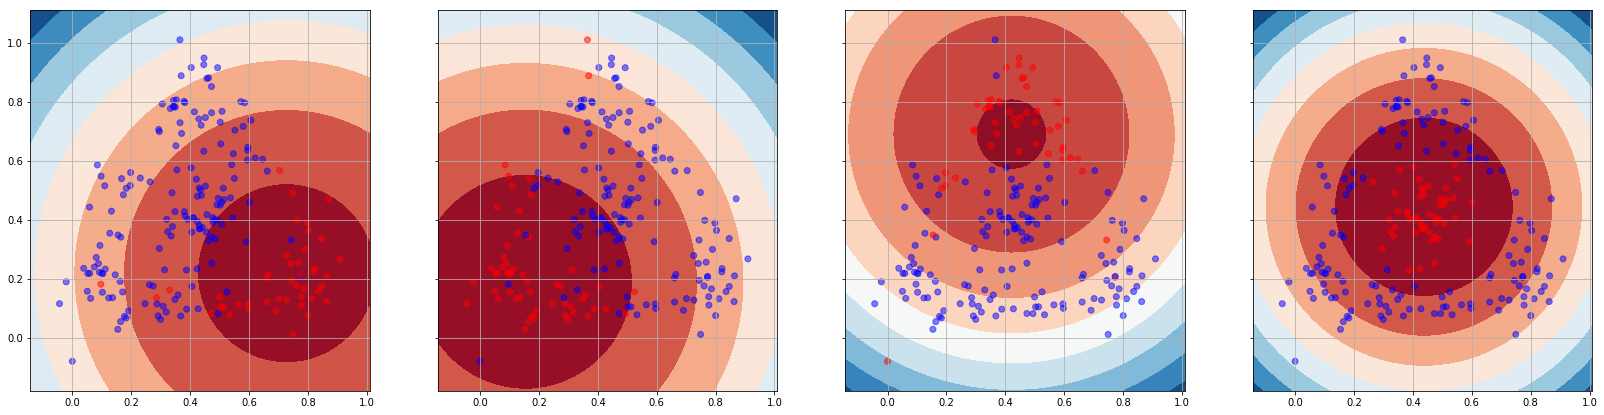

In [28]:
n_cls=len(set(y_train))
ph=7
pw=ph*n_cls

f, axarr = plt.subplots(1,n_cls, sharey=True, sharex=True, figsize=(pw,ph),)
    
for c in sorted(set(y_train)):     
    clr = [ ['b','r'][ int(j==c) ] for j in y_test  ]
    axarr[c].contourf(xx, yy, 1.0-pp[c].reshape(n,n), cmap=plt.cm.RdBu)
    axarr[c].scatter( x=X_test[:,0], y=X_test[:,1], c=clr, alpha=.5 )
    axarr[c].grid()

plt.show()

In [29]:
# r = np.argmax(pp[c])
# r//n, r%n